# JOJOGan

### Transform photos into various images styles.

Original Author: [Min Jin Chong](https://github.com/mchong6)

Provided by: [BreezeWhite](https://github.com/BreezeWhite)

Original Github: https://github.com/mchong6/JoJoGAN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BreezeWhite/interesting-colabs/blob/main/scripts/JoJoGAN.ipynb)

In [8]:
#@title Setup

!git clone https://github.com/mchong6/JoJoGAN.git
%cd JoJoGAN

!pip install \
  tqdm \
  scikit-learn==0.22 \
  scipy \
  lpips \
  dlib \
  opencv-python \
  wandb

!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2
!mkdir models
!mv shape_predictor_68_face_landmarks.dat models/dlibshape_predictor_68_face_landmarks.dat
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!unzip ninja-linux.zip -d /usr/local/bin/
!update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force

%load_ext autoreload
%autoreload 2

import os
import re
import math
import random
import subprocess
from PIL import Image
from copy import deepcopy
from argparse import Namespace

import numpy as np
import torch
torch.backends.cudnn.benchmark = True
from torchvision import transforms, utils
from torch import nn, autograd, optim
from torch.nn import functional as F

from util import align_face
from model import Generator
from e4e.models.psp import pSp


os.makedirs('checkpoints', exist_ok=True)
CHECKPOINT_URL = 'https://github.com/BreezeWhite/interesting-colabs/releases/download/jojogan'


def download_checkpoint(mode):
  if os.path.exists(f'checkpoints/{mode}.pt'):
    return

  print('Downloading checkpoint...')
  result = subprocess.run(
    f'wget {CHECKPOINT_URL}/{mode}.pt -O checkpoints/{mode}.pt',
    shell=True,
    capture_output=True
  )
  result.check_returncode()


LATENT_DIM = 512
AVAILABLE_MODES = {
    "stylegan2",
    "e4e_ffhq",
    "restyle_psp",
    "arcane_caitlyn",
    "arcane_caitlyn_preserve_color",
    "arcane_jinx_preserve_color",
    "arcane_jinx",
    "arcane_multi_preserve_color",
    "arcane_multi",
    "sketch_multi",
    "disney",
    "disney_preserve_color",
    "jojo",
    "jojo_preserve_color",
    "jojo_yasuho",
    "jojo_yasuho_preserve_color",
    "art",
}

generator = Generator(1024, LATENT_DIM, 8, 2).to('cuda')
transform = transforms.Compose(
  [
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ]
)


@ torch.no_grad()
def e4e_projection(aligned_face, device='cuda'):
  download_checkpoint('e4e_ffhq')
  model_path = 'checkpoints/e4e_ffhq.pt'
  ckpt = torch.load(model_path, map_location='cpu')
  opts = ckpt['opts']
  opts['checkpoint_path'] = model_path
  opts= Namespace(**opts)
  net = pSp(opts, device).eval().to(device)

  transform = transforms.Compose(
    [
      transforms.Resize(256),
      transforms.CenterCrop(256),
      transforms.ToTensor(),
      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
  )

  img = transform(aligned_face).unsqueeze(0).to(device)
  images, w_plus = net(img, randomize_noise=False, return_latents=True)
  return w_plus[0].unsqueeze(0)


def tensor_to_image(tensor, size=None, mode='nearest'):
    # image is [3,h,w] or [1,3,h,w] tensor [0,1]
    if not isinstance(tensor, torch.Tensor):
        tensor = transforms.ToTensor()(tensor).unsqueeze(0)
    if tensor.is_cuda:
        tensor = tensor.cpu()
    if size is not None and tensor.size(-1) != size:
        tensor = F.interpolate(tensor, size=(size,size), mode=mode)
    if tensor.dim() == 4:
        tensor = tensor[0]
    arr = tensor.permute(1, 2, 0).detach().numpy()
    normalized = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    return Image.fromarray(normalized.astype(np.uint8))

Saving womanyellingcat.jpg to womanyellingcat.jpg


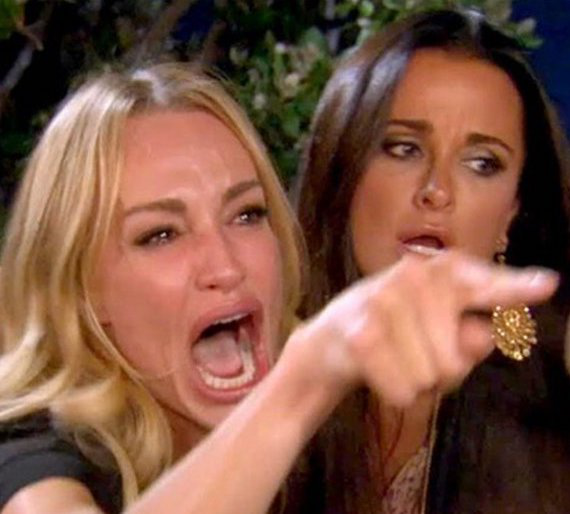

In [39]:
#@title Upload Image
from google.colab import files
from IPython.display import display

ff = files.upload()
img_name = list(ff.keys())[0]

display(Image.open(img_name))
aligned_face = align_face(img_name)

Loading e4e over the pSp framework from checkpoint: checkpoints/e4e_ffhq.pt


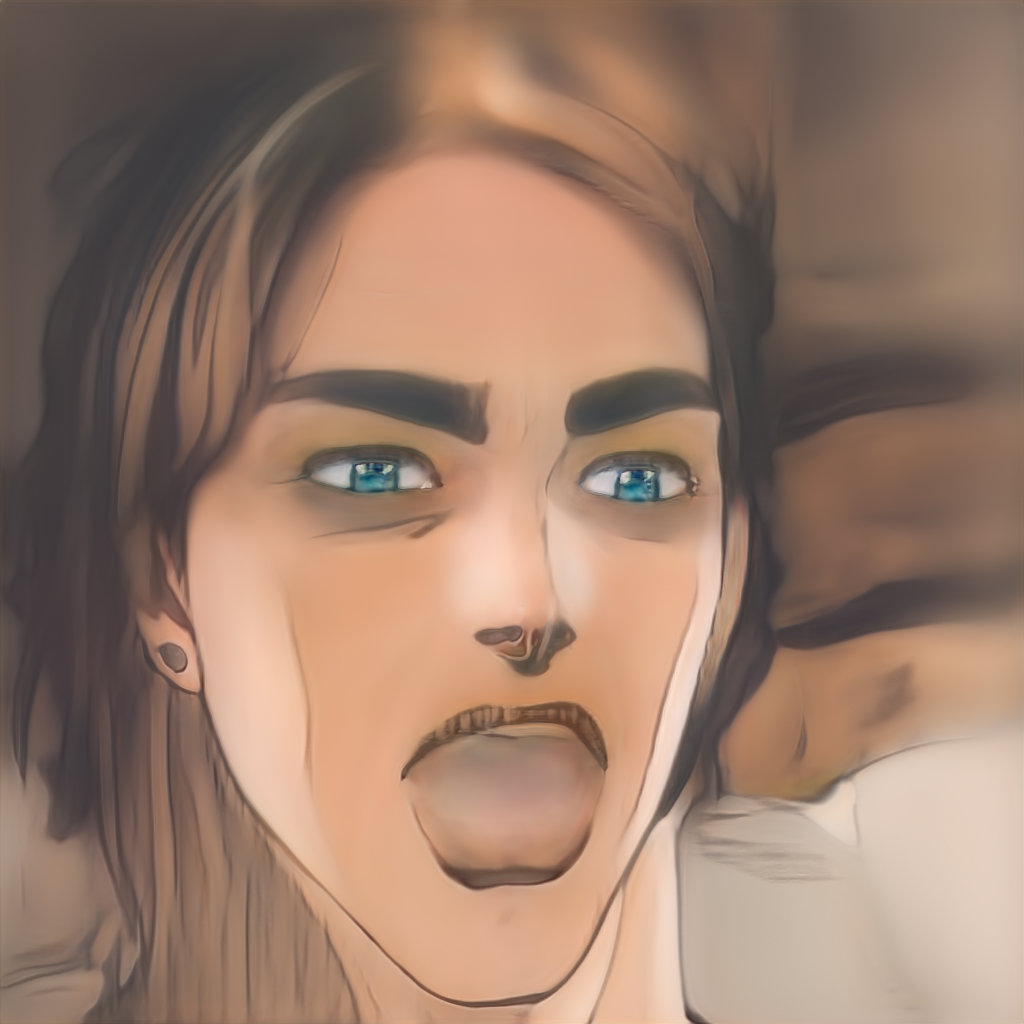

In [40]:
#@title Run

#@markdown Preserve color tries to preserve color of original image by limiting family of allowable transformations. Otherwise, the stylized image will inherit the colors of the reference images, leading to heavier stylizations.
preserve_color = False  #@param{type:"boolean"}
mode = 'jojo'  #@param ['art', 'arcane_multi', 'sketch_multi', 'arcane_jinx', 'arcane_caitlyn', 'jojo_yasuho', 'jojo', 'disney', 'stylegan2', 'restyle_psp']

# Prepare the checkpoint
if preserve_color and f'{mode}_preserve_color' in AVAILABLE_MODES:
  mode += '_preserve_color'
download_checkpoint(mode)

# Special case for StyleGan2
ckpt_key = 'g'
if mode == 'stylegan2':
  ckpt_key = 'g_ema'

# Model setup
ckpt_path = f'checkpoints/{mode}.pt'
ckpt = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
generator.load_state_dict(ckpt[ckpt_key], strict=False)

my_w = e4e_projection(aligned_face)
with torch.no_grad():
  generator.eval()
  output = generator(my_w, input_is_latent=True)

out_img = tensor_to_image(output)
display(out_img)